# Preparing Data
----

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls drive/MyDrive/Chess

Checkpoint2.h5	train.csv  train.zip  val.csv  val.zip


In [4]:
!unzip drive/MyDrive/Chess/train.zip > /dev/null
!unzip drive/MyDrive/Chess/val.zip > /dev/null


In [5]:
!cp drive/MyDrive/Chess/train.csv ./
!cp drive/MyDrive/Chess/val.csv ./

In [6]:
!pip install chess

     |████████████████████████████████| 153kB 9.1MB/s 


# Importing Packages

In [7]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [8]:
train_df = pd.read_csv('train.csv')
train_df

,ImageID,label
0,0,1rbqkb1r/p1p1n1pp/1pn1p3/1P1p1p2/3P4/N3B2P/P1P...
1,1,2bk4/2q1p3/3p3P/5r2/r5nP/P2K2N1/8/2q1NB1R
2,2,3rnq2/3k1p2/5rP1/pppp1P2/P1BP2P1/RPP1K2N/3B3P/...
3,3,r4br1/1p2ppp1/3k2Pp/p2P3n/2pP1N2/P1P1K3/nP5P/1...
4,4,4kn2/8/p6b/1p6/P1p1p1pr/1P2P1N1/1R1r3P/1K2R1N1
...,...,...
39995,39995,r7/B6k/2pp1bpP/8/1p6/1P3P2/5N2/5KRB
39996,39996,r5B1/1b2k1b1/4Npp1/p3P3/P2p1P2/1R2P3/2P2KqP/1Q...
39997,39997,6n1/k7/1pP5/1P1pP1n1/p4PBP/R6b/2Kb4/3N2R1
39998,39998,r1b1qk2/3n4/1pp1nb2/p3p1Nr/2p3Pp/PP2P2P/R2PBP1...


In [9]:
val_df = pd.read_csv('val.csv')
val_df

,ImageID,label
0,0,7r/2k5/8/8/Pp2P3/RP5r/2R5/K2R1b2
1,1,r1bq1b2/2pppkpr/p6n/5p1p/P1pn1P2/4BNPP/R2KP3/1...
2,2,r1b2br1/p1ppq2p/np1k1pp1/4p1B1/3P2PP/P4P2/1PP1...
3,3,r2r4/pp4bp/4BN1n/1P1pkb2/1n1p2Pp/P1N1Pp2/1BP5/...
4,4,2r3nr/1bppk3/5q1p/p1P1pPp1/1n3P2/1pPK3P/1P2PR2...
...,...,...
3995,3995,8/1r3pBr/2Pk4/2p4p/5P1R/1P4P1/P4K2/5B2
3996,3996,4rkn1/ppp5/3q4/PN1pppPP/2PP1b2/N1B2r1P/2B3K1/Q...
3997,3997,nk6/5p1r/6Pp/1P1pNK1P/1P3bB1/4p3/3R4/7q
3998,3998,rn3bn1/pp4p1/Pqp1bk2/3pp2r/2B2p2/4P2P/RPPP1PP1...


## Sample images

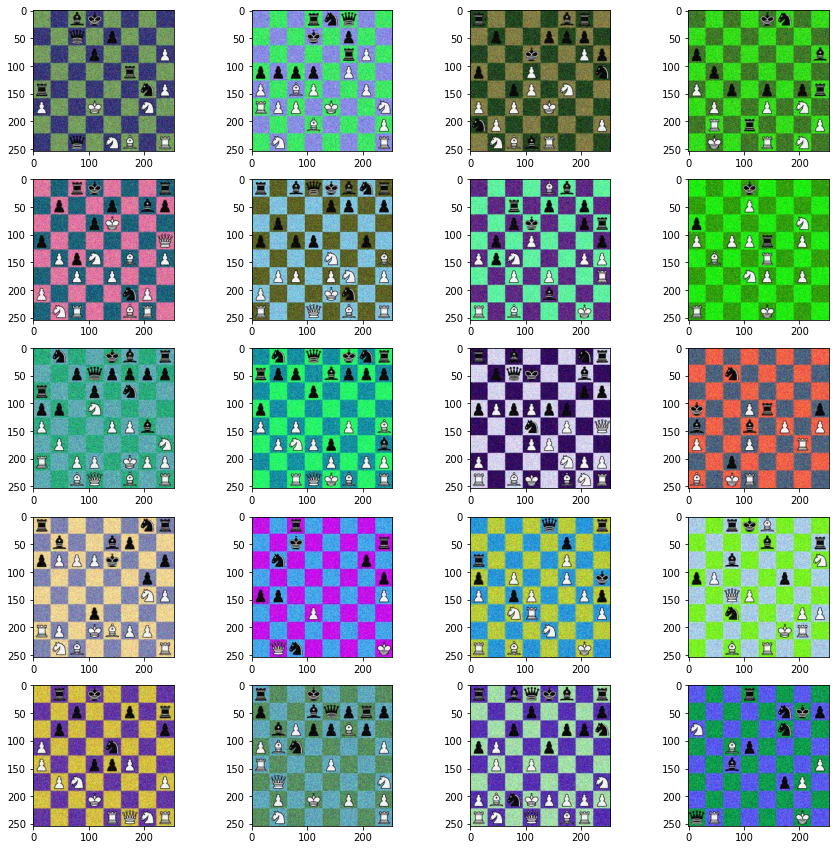

In [10]:
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread('train/'+str(train_df.iloc[i]['ImageID'])+'.jpg')
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [11]:
train_df.iloc[0].label

'1rbqkb1r/p1p1n1pp/1pn1p3/1P1p1p2/3P4/N3B2P/P1PNPPP1/R2QKB1R'

#Parsing FEN notation

In [12]:
import chess
import numpy as np

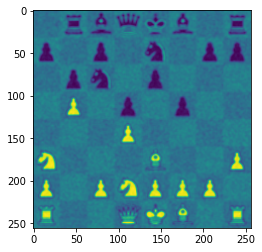

In [13]:
img = cv2.imread('train/'+str(train_df.iloc[0]['ImageID'])+'.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
plt.imshow(img)

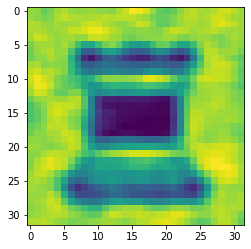

In [14]:
plt.imshow(img[:32, 32:64])

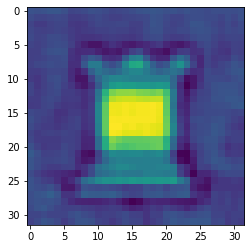

In [15]:
plt.imshow(img[-32:, -32:])


In [16]:
board = chess.Board(train_df.iloc[0].label)
print(board)

. r b q k b . r
p . p . n . p p
. p n . p . . .
. P . p . p . .
. . . P . . . .
N . . . B . . P
P . P N P P P .
R . . Q K B . R


In [17]:
print(board.piece_at(chess.parse_square('a3')))

N


In [18]:
for square in chess.SquareSet(chess.BB_ALL):
  print(str(board.piece_at(square)))

R
None
None
Q
K
B
None
R
P
None
P
N
P
P
P
None
N
None
None
None
B
None
None
P
None
None
None
P
None
None
None
None
None
P
None
p
None
p
None
None
None
p
n
None
p
None
None
None
p
None
p
None
n
None
p
p
None
r
b
q
k
b
None
r


In [19]:
def encode_piece(piece: str):
  if piece == 'None':
    return 0
  elif piece == 'K':
    return 1
  elif piece == 'Q':
    return 2
  elif piece == 'R':
    return 3
  elif piece == 'B':
    return 4
  elif piece == 'N':
    return 5
  elif piece == 'P':
    return 6
  elif piece == 'k':
    return 7
  elif piece == 'q':
    return 8
  elif piece == 'r':
    return 9
  elif piece == 'b':
    return 10
  elif piece == 'n':
    return 11
  else:
    return 12
  
def preprocess_image(path: str):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  img = cv2.resize(img ,(256, 256))
  img = cv2.GaussianBlur(img,(3,3),cv2.BORDER_DEFAULT)
  cells = []
  for i in range(256-32, -1, -32):
    for j in range(0, 256-31, 32):
      cells.append(img[i: i+32, j: j+32])
  cells = np.array(cells)
  return cells

In [20]:
preprocess_image('train/'+str(train_df.iloc[0]['ImageID'])+'.jpg').shape

(64, 32, 32)

In [21]:
X = []
y = []

for i in tqdm(range(len(train_df))):
  imgID = str(train_df.iloc[i]['ImageID'])
  img_path = 'train/'+imgID+'.jpg'

  x = preprocess_image(img_path)
  X.extend(x)

  fen = train_df.iloc[i]['label']
  board = chess.Board(fen)
  for square in chess.SquareSet(chess.BB_ALL):
    y.append(encode_piece(str(board.piece_at(square))))


X = np.array(X)
y = np.array(y)
print('X is: ', X.shape)
print('Y is: ', y.shape)

100%|██████████| 40000/40000 [01:11<00:00, 563.08it/s]


X is:  (2560000, 32, 32)
Y is:  (2560000,)


In [22]:
X_test = []
y_test = []

for i in tqdm(range(len(val_df))):
  imgID = str(val_df.iloc[i]['ImageID'])
  img_path = 'val/'+imgID+'.jpg'

  x = preprocess_image(img_path)
  X_test.extend(x)

  fen = val_df.iloc[i]['label']
  board = chess.Board(fen)
  for square in chess.SquareSet(chess.BB_ALL):
    y_test.append(encode_piece(str(board.piece_at(square))))


X_test = np.array(X_test)
y_test = np.array(y_test)
print('X is: ', X_test.shape)
print('Y is: ', y_test.shape)

100%|██████████| 4000/4000 [00:07<00:00, 566.81it/s]


X is:  (256000, 32, 32)
Y is:  (256000,)


#Undersampling Dataset

In [23]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
Counter(y)

Counter({0: 1674787,
         1: 40000,
         2: 21592,
         3: 65308,
         4: 55889,
         5: 53949,
         6: 205409,
         7: 40000,
         8: 21698,
         9: 65247,
         10: 56182,
         11: 54384,
         12: 205555})

#### Pie chart of Class Distribution

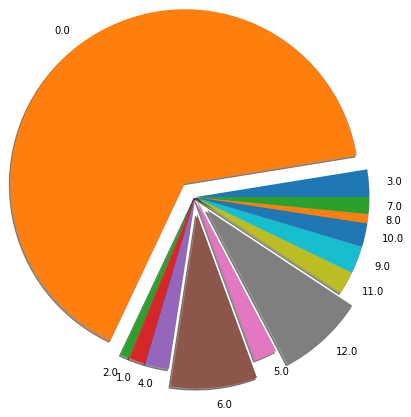

In [25]:
counts = Counter(y)
plt.pie([float(v) for v in counts.values()], labels=[float(k) for k in counts],
           autopct=None, radius=2, shadow=True,explode=(0, 0.2, 0, 0, 0, 0.2, 0, 0.2, 0, 0, 0, 0, 0))
plt.show()

In [26]:
X_reshaped = X.reshape(X.shape[0], -1)
print('Reshaped X is: ', X_reshaped.shape)


Reshaped X is:  (2560000, 1024)


In [27]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_reshaped, y)
print('Resampled dataset shape %s' % Counter(y_res))
X_back = X_res.reshape(X_res.shape[0], 32, 32)
print('X_back is: ', X_back.shape)
print('y is: ', y_res.shape)

Resampled dataset shape Counter({0: 21592, 1: 21592, 2: 21592, 3: 21592, 4: 21592, 5: 21592, 6: 21592, 7: 21592, 8: 21592, 9: 21592, 10: 21592, 11: 21592, 12: 21592})
X_back is:  (280696, 32, 32)
y is:  (280696,)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [28]:
Counter(y_res)

Counter({0: 21592,
         1: 21592,
         2: 21592,
         3: 21592,
         4: 21592,
         5: 21592,
         6: 21592,
         7: 21592,
         8: 21592,
         9: 21592,
         10: 21592,
         11: 21592,
         12: 21592})

#### Pie Chart after under sampling the dataset

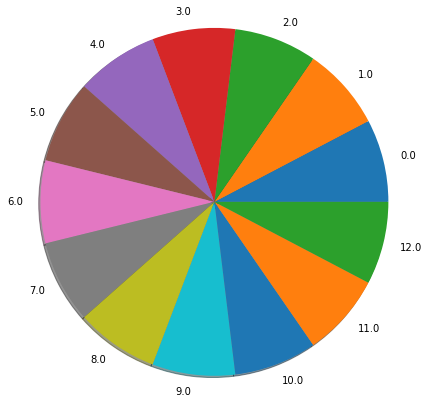

In [29]:
counts = Counter(y_res)
plt.pie([float(v) for v in counts.values()], labels=[float(k) for k in counts],
           autopct=None, radius=2, shadow=True,)
plt.show()

In [30]:
from keras.utils.np_utils import to_categorical 

In [31]:
y_res_one_hot = to_categorical(y_res, num_classes=13)
print('Shape of [y_res_one_hot]: ', y_res_one_hot.shape)
y_test_one_hot=to_categorical(y_test,num_classes=13)
print('Shape of [y_test_one_hot]: ', y_test_one_hot.shape)

Shape of [y_res_one_hot]:  (280696, 13)
Shape of [y_test_one_hot]:  (256000, 13)


In [32]:
X = X.reshape(X.shape[0], 32,32, 1)

In [33]:
y_one_hot = to_categorical(y, num_classes=13)

In [34]:
X_back=X_res.reshape(X_res.shape[0],32,32,1)
X_test=X_test.reshape(X_test.shape[0],32,32,1)


In [35]:
print('Shape of [X_back] is: ', X_back.shape)

Shape of [X_back] is:  (280696, 32, 32, 1)


# Model



In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,Flatten

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=3)

## Training model


In [44]:
model=Sequential()
model.add(Conv2D(16, (3,3), padding='same', activation="relu",input_shape=(32,32,1)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(13,activation='softmax'))


In [45]:
from tensorflow.keras.optimizers import Adam

In [46]:
optimizer=Adam(lr=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [48]:
history = model.fit(X_back, y_res_one_hot,validation_data=(X_test,y_test_one_hot), epochs=50, batch_size=1024, callbacks=[es])

Epoch 1/50
275/275 [==============================] - 35s 16ms/step - loss: 25.4085 - accuracy: 0.0699 - val_loss: 31.8399 - val_accuracy: 0.0181
Epoch 2/50
275/275 [==============================] - 4s 14ms/step - loss: 18.5913 - accuracy: 0.1264 - val_loss: 25.1880 - val_accuracy: 0.0231
Epoch 3/50
275/275 [==============================] - 4s 14ms/step - loss: 13.8911 - accuracy: 0.1489 - val_loss: 19.2240 - val_accuracy: 0.0259
Epoch 4/50
275/275 [==============================] - 4s 14ms/step - loss: 10.2435 - accuracy: 0.1613 - val_loss: 14.2769 - val_accuracy: 0.0323
Epoch 5/50
275/275 [==============================] - 4s 14ms/step - loss: 7.6708 - accuracy: 0.1816 - val_loss: 9.5259 - val_accuracy: 0.0381
Epoch 6/50
275/275 [==============================] - 4s 14ms/step - loss: 5.3936 - accuracy: 0.1967 - val_loss: 5.4462 - val_accuracy: 0.0497
Epoch 7/50
275/275 [==============================] - 4s 14ms/step - loss: 3.7391 - accuracy: 0.2132 - val_loss: 3.4406 - val_accurac

### Plotting model learning characteristics

#### Accuracy Plot

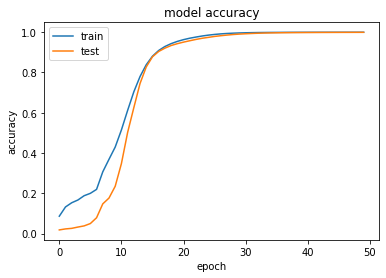

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#### Loss Plot

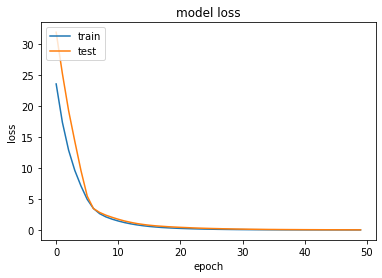

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Classification Report

In [56]:
y_pred=model.predict(X_test)

In [57]:
y_pred=np.argmax(y_pred,axis=1)

In [58]:
y_pred.shape


(256000,)

In [80]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification report:\n", classification_report(y_pred=y_pred,y_true=y_test))

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    167461
           1       1.00      1.00      1.00      4000
           2       1.00      1.00      1.00      2163
           3       1.00      1.00      1.00      6530
           4       1.00      1.00      1.00      5584
           5       1.00      1.00      1.00      5371
           6       1.00      1.00      1.00     20501
           7       1.00      1.00      1.00      4000
           8       1.00      1.00      1.00      2160
           9       1.00      1.00      1.00      6614
          10       1.00      1.00      1.00      5601
          11       1.00      1.00      1.00      5429
          12       0.99      1.00      1.00     20586

    accuracy                           1.00    256000
   macro avg       1.00      1.00      1.00    256000
weighted avg       1.00      1.00      1.00    256000



In [60]:
model.save('/content/drive/MyDrive/Chess/Checkpoint_Final.h5')

# Generating FEN on test set

## Loading saved model from checkpoint

In [61]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Chess/Checkpoint_Final.h5')

In [62]:
def decode_piece(piece: int):
  if piece == 0:
    return None
  elif piece == 1:
    return 'K'
  elif piece == 2:
    return 'Q'
  elif piece == 3:
    return 'R'
  elif piece == 4:
    return 'B'
  elif piece == 5:
    return 'N'
  elif piece == 6:
    return 'P'
  elif piece == 7:
    return 'k'
  elif piece == 8:
    return 'q'
  elif piece == 9:
    return 'r'
  elif piece == 10:
    return 'b'
  elif piece == 11:
    return 'n'
  else:
    return 'p'

## Loading Test Data

In [63]:
X_val = []
y_val = []

for i in tqdm(range(len(val_df))):
  imgID = str(val_df.iloc[i]['ImageID'])
  img_path = 'val/'+imgID+'.jpg'

  x = preprocess_image(img_path)
  X_val.append(x)

  fen = val_df.iloc[i]['label']
  # board = chess.Board(fen)
  # for square in chess.SquareSet(chess.BB_ALL):
  #   y.append(encode_piece(str(board.piece_at(square))))
  y_val.append(fen)

X_val = np.array(X_val)
# y = np.array(y)
print('X is: ', X_val.shape)
print('Y is: ', len(y_val))

100%|██████████| 4000/4000 [00:05<00:00, 682.06it/s]


X is:  (4000, 64, 32, 32)
Y is:  4000


In [64]:
def get_fen_image(cells):
  global model
  cells = cells.reshape(-1, 32, 32, 1)
  y_pred = model.predict(cells)
  y_pred = np.argmax(y_pred, axis=1)
  pieces = []
  board = chess.Board()
  board.clear_board()
  for i in y_pred:
    pieces.append(decode_piece(i))
  for counter, square in enumerate(chess.SquareSet(chess.BB_ALL)):
      if pieces[counter] is not None:
        piece = chess.Piece.from_symbol(pieces[counter])
        board.set_piece_at(square, piece)
  return board.fen().split(' ')[0]

In [70]:
predicted_fen_array = []
for example in tqdm(X_val):
  predicted_fen = get_fen_image(example)
  predicted_fen_array.append(predicted_fen)

100%|██████████| 4000/4000 [01:53<00:00, 35.29it/s]


In [71]:
val_df['PredictedFEN'] = predicted_fen_array

In [72]:
val_df

,ImageID,label,PredictedFEN
0,0,7r/2k5/8/8/Pp2P3/RP5r/2R5/K2R1b2,7r/2k5/8/8/Pp2P3/RP5r/2R5/K2R1b2
1,1,r1bq1b2/2pppkpr/p6n/5p1p/P1pn1P2/4BNPP/R2KP3/1...,r1bq1b2/2pppkpr/p6n/5p1p/P1pn1P2/4BNPP/R2KP3/1...
2,2,r1b2br1/p1ppq2p/np1k1pp1/4p1B1/3P2PP/P4P2/1PP1...,r1b2br1/p1ppq2p/np1k1pp1/4p1B1/3P2PP/P4P2/1PP1...
3,3,r2r4/pp4bp/4BN1n/1P1pkb2/1n1p2Pp/P1N1Pp2/1BP5/...,r2r4/pp4bp/4BN1n/1P1pkb2/1n1p2Pp/P1N1Pp2/1BP5/...
4,4,2r3nr/1bppk3/5q1p/p1P1pPp1/1n3P2/1pPK3P/1P2PR2...,2r3nr/1bppk3/5q1p/p1P1pPp1/1n3P2/1pPK3P/1P2PR2...
...,...,...,...
3995,3995,8/1r3pBr/2Pk4/2p4p/5P1R/1P4P1/P4K2/5B2,8/1r3pBr/2Pk4/2p4p/5P1R/1P4P1/P4K2/5B2
3996,3996,4rkn1/ppp5/3q4/PN1pppPP/2PP1b2/N1B2r1P/2B3K1/Q...,4rkn1/ppp5/3q4/PN1pppPP/2PP1b2/N1B2r1P/2B3K1/Q...
3997,3997,nk6/5p1r/6Pp/1P1pNK1P/1P3bB1/4p3/3R4/7q,nk6/5p1r/6Pp/1P1pNK1P/1P3bB1/4p3/3R4/7q
3998,3998,rn3bn1/pp4p1/Pqp1bk2/3pp2r/2B2p2/4P2P/RPPP1PP1...,rn3bn1/pp4p1/Pqp1bk2/3pp2r/2B2p2/4P2P/RPPP1PP1...


In [73]:
!pip install jiwer

In [74]:
import jiwer

In [75]:
print("Word Error Rate[WER]: ", jiwer.wer(list(val_df['label']), list(val_df['PredictedFEN'])))

Word Error Rate[WER]:  0.01425


In [ ]:
# String1: Sky is blue today
# Strinb2: SKy am red today

# Confusion matrix

In [81]:
#confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0,1,2,3,4,5,6,7,8,9,10,11,12], sample_weight=None, normalize=None)

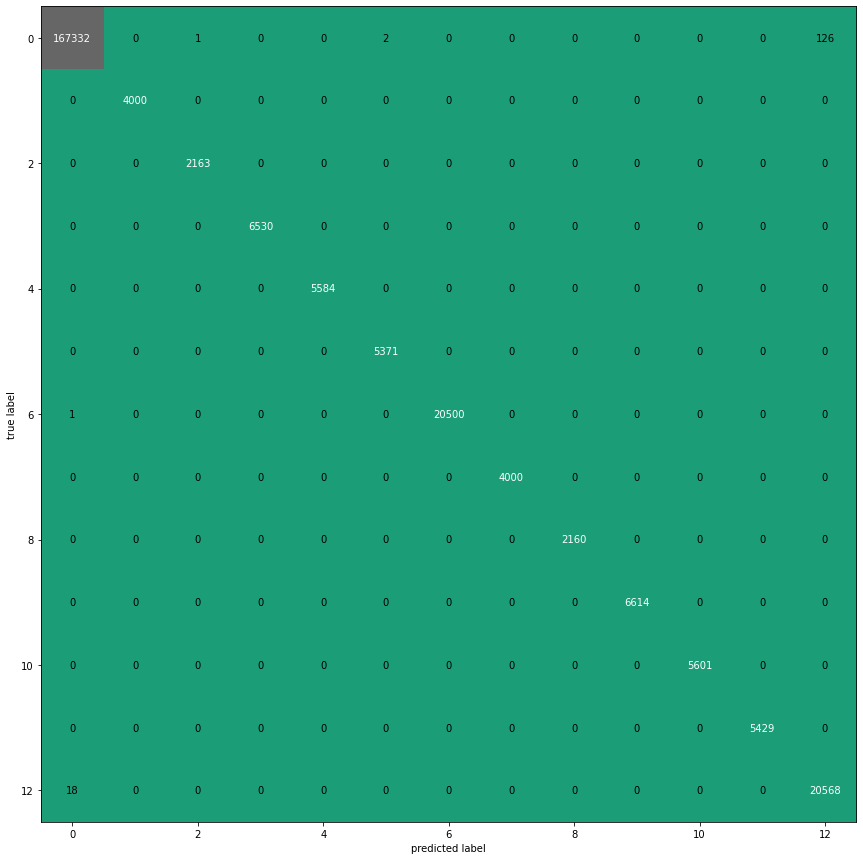

In [82]:
#confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix

plot_confusion_matrix(cm, figsize=(15,15), cmap=plt.cm.Dark2 )

plt.show()

# Testing with sample image not in either dataset

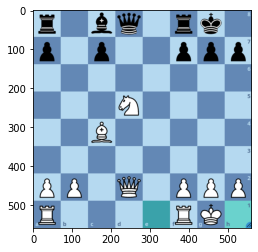

In [76]:
# Image generated usign lichess
img = cv2.imread('/content/drive/MyDrive/Chess/test.png', cv2.IMREAD_COLOR)
plt.imshow(img)
plt.show()

In [77]:
print('FEN is: r1bq1rk1/p1p2ppp/8/3N4/2B5/8/PP1Q1PPP/R4RK1')

FEN is: r1bq1rk1/p1p2ppp/8/3N4/2B5/8/PP1Q1PPP/R4RK1


In [78]:
data = preprocess_image('/content/drive/MyDrive/Chess/test.png')
print("Predicted FEN: ", get_fen_image(data))

Predicted FEN:  r1bq1rk1/p1p2ppp/8/3N4/2B5/8/PP1Q1PPP/R4RK1
